In [18]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.datasets import make_classification
#import pandas as pd
#import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from IPython import display
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from collections import defaultdict

import sklearn.datasets

torch.manual_seed(1)
np.random.seed(7)
#sns.set(style="white", palette="muted", color_codes=True, context="talk")

%matplotlib inline
print(torch.__version__) 

1.7.1


In [19]:
import time

# Dataset and Model Definition

In [20]:
n_classes = 2

X, y = sklearn.datasets.make_classification(n_samples=1000,
                                            n_features=20,
                                            n_informative=15,
                                            n_redundant=0,
                                            n_repeated=0,
                                            class_sep=5,
                                            n_classes=n_classes,
                                            random_state = 4)
X = X / np.max(X, axis=0)
n_features = X.shape[1]

In [267]:
from sklearn.datasets import make_moons
X, y = make_moons(noise=0.1, random_state=0, n_samples=1000)
X = X / np.max(X, axis=0)
n_features = X.shape[1]

In [1269]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, random_state=7)
print('len train:', len(X_train))
print('len test:', len(X_test))

len train: 800
len test: 200


In [1313]:
BATCH_SIZE = 800

training_dataset = TensorDataset(torch.from_numpy(X_train).float(), 
                                 torch.from_numpy(y_train).long())
train_loader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

testing_dataset = TensorDataset(torch.from_numpy(X_test).float(), 
                                torch.from_numpy(y_test).long())
test_loader = DataLoader(testing_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [1445]:
n_hidden = 64
class Classifier(nn.Module):
    def __init__(self, n_features, n_hidden=n_hidden):
        super(Classifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, 1),
            #nn.ReLU(),
            #nn.LogSoftmax()
        )

    def forward(self, x):
        return torch.sigmoid(self.network(x))

In [1446]:
def accuracy(model, X, y):
    Xt = torch.from_numpy(X).float()
    yt = torch.from_numpy(y).long()
    outputs = model(Xt)
    y_hat = [1 if o>.5 else 0 for o in outputs]
    accuracy = np.sum(y_hat == y) / len(y)
    return accuracy

# Training

In [1447]:
def make_plot(info, key, title):
    plt.plot(info[key]);
    plt.title(title)
    plt.show()

In [1512]:
UPSTREAM_GRAD_BOUND = 0.001
INPUT_BOUND = 5.

In [1513]:
def clamp_grad(self, grad_input, grad_output):
    if isinstance(self, nn.Linear):
        bias_g, upstream_g, weights_g = grad_input
        upstream_g_c = upstream_g.clamp(-UPSTREAM_GRAD_BOUND, UPSTREAM_GRAD_BOUND)
        return (bias_g, upstream_g_c, weights_g)
    elif isinstance(self, (nn.Tanh, nn.ReLU)):
        upstream_g = grad_input[0]
        upstream_g_c = upstream_g.clamp(-UPSTREAM_GRAD_BOUND, UPSTREAM_GRAD_BOUND)
        return (upstream_g_c,)
    else:
        print('unknown')

In [1514]:
def clamp_grad(self, grad_input, grad_output):
    return tuple([x.clamp(-UPSTREAM_GRAD_BOUND, UPSTREAM_GRAD_BOUND) for x in grad_input])

In [1515]:
def clamp_input(self, input):
    #print('max:', input[0].abs().max(), 'mean:', input[0].abs().mean())
    return tuple([x.clamp(-INPUT_BOUND, INPUT_BOUND) for x in input])

In [1516]:
def zcdp_eps(rho, delta):
    return rho + 2*np.sqrt(rho*np.log(1/delta))

In [1523]:
def run_experiment(epsilon, epochs, add_noise=False):
    model = Classifier(n_features=n_features)
    model_criterion = nn.BCELoss() 
    model_optimizer = optim.Adam(model.parameters(), lr=0.01)#, weight_decay=0.0001)
    rho_i = 0.00001
    total_rho = 0
    
    for x in model.network:
        x.register_backward_hook(clamp_grad)
        x.register_forward_pre_hook(clamp_input)
    
    sensitivities = []
    norms = []
    decays = []
    losses = []

    for epoch in range(epochs):
        for x_batch_train, y_batch_train in train_loader:
            model_optimizer.zero_grad()
            inp = Variable(x_batch_train, requires_grad=True)
            outputs = model.forward(inp)
            loss = model_criterion(outputs, y_batch_train.unsqueeze(1).float())
            losses.append(loss)
            loss.backward()
            
            for i, layer in enumerate(model.network):
                if isinstance(layer, nn.Linear):
                    ps = list(layer.parameters())
                    weights = ps[0]
                    bias = ps[1]
                    input_len = weights.shape[1]
                    output_len = weights.shape[0]
                    fake_inputs = torch.full((1, input_len), INPUT_BOUND)
                    fake_upstream_grad = torch.full((1, output_len), UPSTREAM_GRAD_BOUND)
                    fake_grad = fake_inputs.T @ fake_upstream_grad
                    grad_bound = fake_grad.flatten().norm(p=2)

                    actual_grad_bound = weights.grad.flatten().norm(p=2)
                    if False and actual_grad_bound > grad_bound:
                        print('grad bound norm: ', grad_bound)
                        print('actual grad norm:', actual_grad_bound)
                    sensitivities.append(grad_bound)
                    
                    sensitivity = grad_bound / BATCH_SIZE
                    sigma = np.sqrt(sensitivity**2 / (2*rho_i))
                    with torch.no_grad():
                        weights.grad += sigma*torch.randn(weights.shape)
                        bias.grad += sigma*torch.randn(bias.shape) # this is more noise than necessary
                    total_rho += rho_i
            
            norms.append(next(model.parameters()).data.norm())

            model_optimizer.step()
            

    total_weights = 0
    for p in model.parameters():
        total_weights += p.flatten().shape[0]
    print('total weights:', total_weights)

    info = {'sens': sensitivities,
            'norms': norms,
            'decays': decays,
            'losses': losses,}
    print('total rho:', total_rho)
    print('total epsilon:', zcdp_eps(total_rho, 1e-5))
    return model, info

total weights: 8577
total rho: 0.004000000000000005
total epsilon: 0.43319320525786975


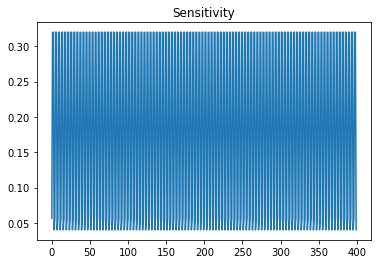

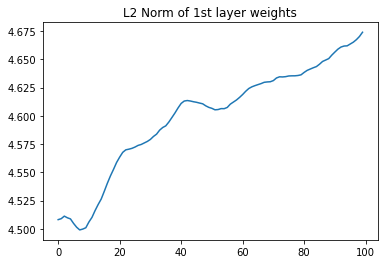

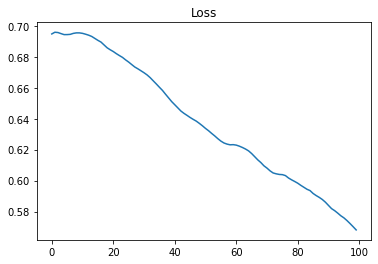

Accuracy: 0.83


In [1526]:
model, info = run_experiment(.001, 100, False)

for key, title in [('sens', 'Sensitivity'), 
                   ('norms', 'L2 Norm of 1st layer weights'),
                   #('decays', 'Weight Decay Value'),
                   ('losses', 'Loss')
                ]:
    make_plot(info, key, title)

print('Accuracy:', accuracy(model, X_test, y_test))